In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [ ]:
# As funções abaixo poderiam ser colocadas em um modulo separado

In [3]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    """
    Set pr=True to enable printing of output.
    
    Output: 
      * iv: float,
      * data: pandas.DataFrame
    """

    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['variable', 'value', 'all', 'good', 'bad'])

    data['share'] = data['all'] / data['all'].sum()
    data['bad_rate'] = data['bad'] / data['all']
    data['distribution_good'] = (data['all'] - data['bad']) / (data['all'].sum() - data['bad'].sum())
    data['distribution_bad'] = data['bad'] / data['bad'].sum()
    data['woe'] = np.log(data['distribution_good'] / data['distribution_bad'])

    data = data.replace({'woe': {np.inf: 0, -np.inf: 0}})

    data['iv'] = data['woe'] * (data['distribution_good'] - data['distribution_bad'])

    data = data.sort_values(by=['variable', 'value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('iv = ', data['iv'].sum())


    iv = data['iv'].sum()
    # print(iv)

    return iv, data

# 1) Read

In [59]:
full_devices = pd.read_csv('full_devices.csv', dtype=str, sep=",", encoding="Latin-1" ) 

In [60]:
full_devices['failure'] = full_devices['failure'].astype(int)
full_devices['attribute2'] = full_devices['attribute2'].astype(int)
full_devices['attribute3'] = full_devices['attribute3'].astype(int)
full_devices['attribute4'] = full_devices['attribute4'].astype(int)
full_devices['attribute5'] = full_devices['attribute5'].astype(int)
full_devices['attribute7'] = full_devices['attribute7'].astype(int)
full_devices['attribute8'] = full_devices['attribute8'].astype(int)
full_devices['attribute9'] = full_devices['attribute9'].astype(int)
full_devices['attribute1'] = full_devices['attribute1'].astype(int)
full_devices['attribute6'] = full_devices['attribute6'].astype(int)

# 2) EAD

In [61]:
len(full_devices)

124494

In [62]:
full_devices.head(3)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0


In [63]:
full_devices['date'].min()

'2015-01-01'

In [64]:
full_devices['date'].max()

'2015-11-02'

In [65]:
full_devices.groupby("failure" , dropna=False)["device"].count().reset_index()

,failure,device
0,0,124388
1,1,106


In [66]:
full_devices.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [67]:
full_devices.groupby("failure" , dropna=False)["attribute1", "attribute2", "attribute3", 
                                               "attribute4", "attribute5", "attribute6",
                                               "attribute7","attribute8", "attribute9"].mean().reset_index()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,0,122384023.53,156.12,9.95,1.70,14.22,260174.25,0.27,0.27,12.44
1,1,127175526.92,4109.43,3.91,54.63,15.46,258303.48,30.62,30.62,23.08


In [68]:
full_devices.groupby(["attribute3", 'failure'] , dropna=False)["device"].count().reset_index()

,attribute3,failure,device
0,0,0,115264
1,0,1,95
2,1,0,3269
3,1,1,5
4,2,0,747
...,...,...,...
49,1326,0,5
50,1331,0,240
51,2112,0,6
52,2693,0,179


## 2.1) Criar novas features

In [12]:
def create_groups(df, var, target):
    #calculate the iv
    iv, data = calc_iv(df, var, target)
    #create categories
    new_name = var + "_g"
    data[new_name] = pd.cut(x=data['iv'], bins=[-10, 0.02, 0.1, 0.3, 0.5, 1],
                        labels=['useless', 'weak', 'medium',
                                'strong', 'suspiciously_good'])
     
    df_final = pd.merge(df, data[['value', new_name]], 
                        left_on = [var], right_on = ['value'] )
    
    df_final = df_final.drop(columns=['value'])
    warnings.filterwarnings('ignore')
    return data, iv, df_final 

In [69]:
#data2, iv, full_devices  =  create_groups(full_devices, 'attribute2', 'failure')
#data3, iv, full_devices  =  create_groups(full_devices, 'attribute3', 'failure')

**Nota**: eu iria testar a categorização por IV, mas abandonei qdo percebi a relação crescente entre atributos e variável resposta.

In [79]:
full_devices['attribute3_g'] = pd.cut(x=full_devices['attribute3'], bins=[-10, 0, 100000],
                    labels=['igual 0', 'maior 0'])

In [80]:
full_devices.groupby(["attribute3_g", 'failure'] , dropna=False)["device"].count().reset_index()

,attribute3_g,failure,device
0,igual 0,0,115264
1,igual 0,1,95
2,maior 0,0,9124
3,maior 0,1,11


## 2.2) analise da correlção entre as variáveis  

<Axes: >

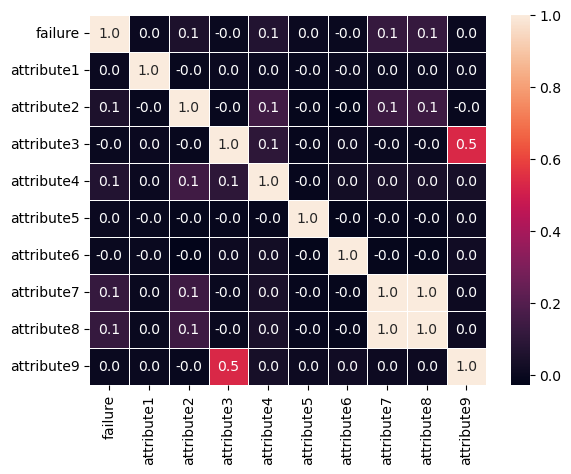

In [84]:
plot = sns.heatmap(full_devices.corr(), annot = True, fmt=".1f", linewidths=.6)
plot

failure          Axes(0.125,0.747241;0.227941x0.132759)
attribute1    Axes(0.398529,0.747241;0.227941x0.132759)
attribute2    Axes(0.672059,0.747241;0.227941x0.132759)
attribute3       Axes(0.125,0.587931;0.227941x0.132759)
attribute4    Axes(0.398529,0.587931;0.227941x0.132759)
attribute5    Axes(0.672059,0.587931;0.227941x0.132759)
attribute6       Axes(0.125,0.428621;0.227941x0.132759)
attribute7    Axes(0.398529,0.428621;0.227941x0.132759)
attribute8    Axes(0.672059,0.428621;0.227941x0.132759)
attribute9        Axes(0.125,0.26931;0.227941x0.132759)
dtype: object

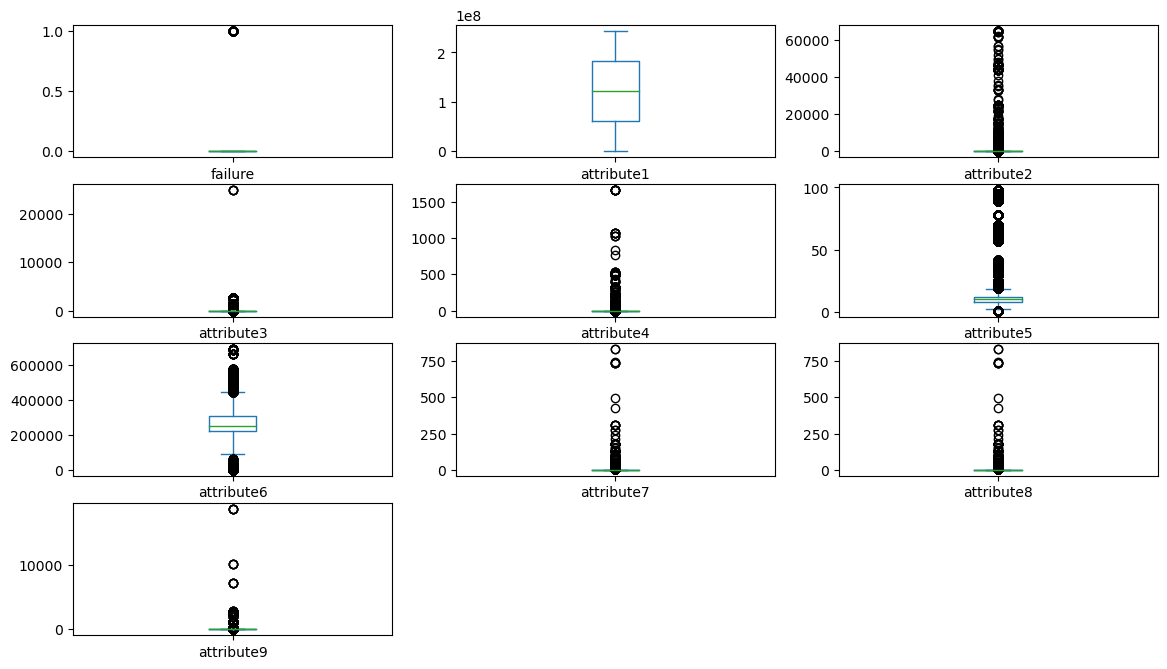

In [85]:
full_devices.plot(kind= 'box' , subplots=True, layout=(5,3),figsize=(14,10))

In [90]:
# Separa decices com e sem falha

In [86]:
failure = full_devices[full_devices.failure == 1] 

In [181]:
failure_devices = full_devices[full_devices.device.isin(failure.device)].reset_index()
no_failure_devices = full_devices[~full_devices.device.isin(failure.device)].reset_index()

attribute2       Axes(0.125,0.747241;0.227941x0.132759)
attribute4    Axes(0.398529,0.747241;0.227941x0.132759)
attribute5    Axes(0.672059,0.747241;0.227941x0.132759)
attribute7       Axes(0.125,0.587931;0.227941x0.132759)
attribute8    Axes(0.398529,0.587931;0.227941x0.132759)
attribute9    Axes(0.672059,0.587931;0.227941x0.132759)
dtype: object

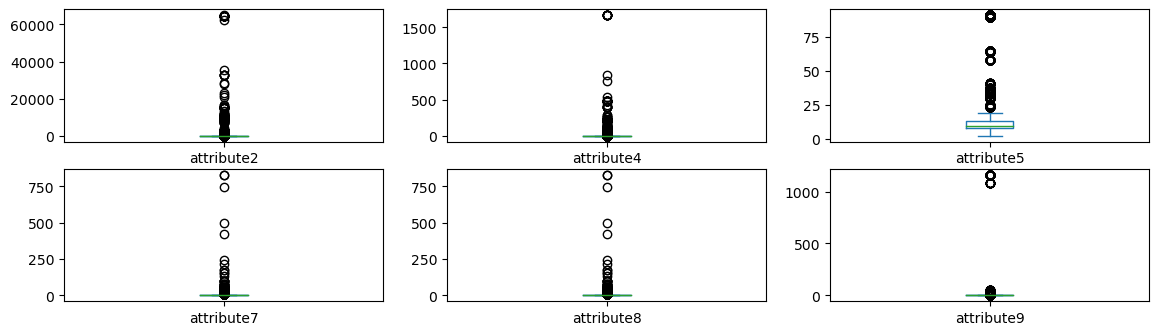

In [91]:
failure_devices[['attribute2', 'attribute4', 'attribute5', 
                 'attribute7', 'attribute8','attribute9']].plot(kind= 'box' , subplots=True, layout=(5,3),figsize=(14,10))

attribute2       Axes(0.125,0.747241;0.227941x0.132759)
attribute4    Axes(0.398529,0.747241;0.227941x0.132759)
attribute5    Axes(0.672059,0.747241;0.227941x0.132759)
attribute7       Axes(0.125,0.587931;0.227941x0.132759)
attribute8    Axes(0.398529,0.587931;0.227941x0.132759)
attribute9    Axes(0.672059,0.587931;0.227941x0.132759)
dtype: object

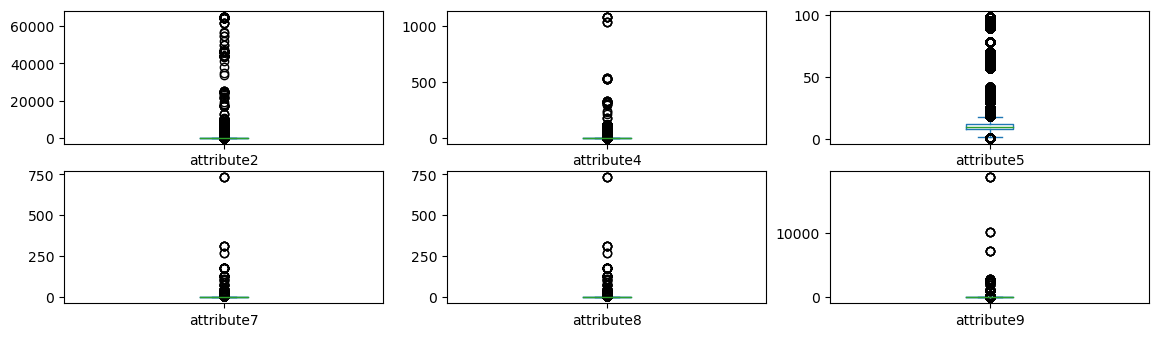

In [92]:
no_failure_devices[['attribute2', 'attribute4', 'attribute5', 
                 'attribute7', 'attribute8','attribute9']].plot(kind= 'box' , subplots=True, layout=(5,3),figsize=(14,10))

# 3) Modelagem 

In [118]:
from pycaret.classification import *
from pycaret.datasets import get_data
import pandas as pd
import random

Como exitem poucos eventos de falham, inicialmente iremos apenas os dispositivos que tiveram falha 

In [132]:
failure_devices_model = failure_devices[['attribute2', 'attribute4', 'attribute5', 
                 'attribute3_g', 'attribute8','attribute9' , 'failure' ]]

In [139]:
failure_devices_model.groupby(['failure'] , dropna=False)["attribute2"].count().reset_index()

,failure,attribute2
0,0,10607
1,1,106


In [133]:
model_clf01 = setup(data = failure_devices_model, target = 'failure', session_id=100)

,Description,Value
0,Session id,100
1,Target,failure
2,Target type,Binary
3,Original data shape,"(10713, 7)"
4,Transformed data shape,"(10713, 7)"
5,Transformed train set shape,"(7499, 7)"
6,Transformed test set shape,"(3214, 7)"
7,Ordinal features,1
8,Numeric features,5
9,Categorical features,1


In [134]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9904,0.7376,0.0643,0.3167,0.1036,0.1023,0.1376,0.0440
ridge,Ridge Classifier,0.9904,0.0000,0.0250,0.2000,0.0444,0.0441,0.0704,0.0330
knn,K Neighbors Classifier,0.9901,0.5315,0.0000,0.0000,0.0000,0.0000,0.0000,0.0580
dummy,Dummy Classifier,0.9901,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0500
ada,Ada Boost Classifier,0.9900,0.6869,0.0250,0.1500,0.0422,0.0412,0.0591,0.0970
gbc,Gradient Boosting Classifier,0.9892,0.7557,0.0929,0.4000,0.1447,0.1412,0.1833,0.1160
svm,SVM - Linear Kernel,0.9889,0.0000,0.0268,0.0833,0.0404,0.0378,0.0438,0.0320
rf,Random Forest Classifier,0.9889,0.6376,0.0375,0.1033,0.0536,0.0509,0.0581,0.1380
et,Extra Trees Classifier,0.9885,0.5407,0.0250,0.0833,0.0382,0.0352,0.0419,0.1410
lightgbm,Light Gradient Boosting Machine,0.9881,0.5928,0.0250,0.0750,0.0367,0.0330,0.0383,0.1180


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [135]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9907,0.7191,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9907,0.5348,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9920,0.7918,0.1429,1.0000,0.2500,0.2482,0.3764
3,0.9907,0.8818,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9893,0.8904,0.0000,0.0000,0.0000,-0.0023,-0.0035
5,0.9893,0.7559,0.1250,0.5000,0.2000,0.1966,0.2463
6,0.9893,0.6455,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9907,0.7155,0.2500,0.6667,0.3636,0.3599,0.4047
8,0.9907,0.7903,0.1250,1.0000,0.2222,0.2204,0.3519


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

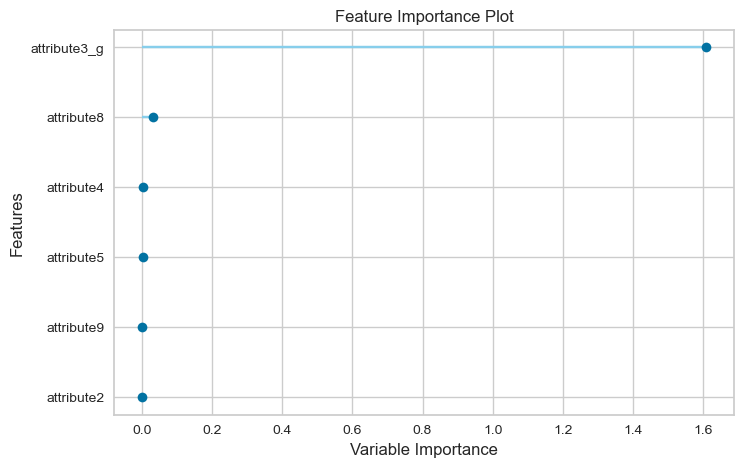

In [136]:
plot_model(lr, plot='feature')

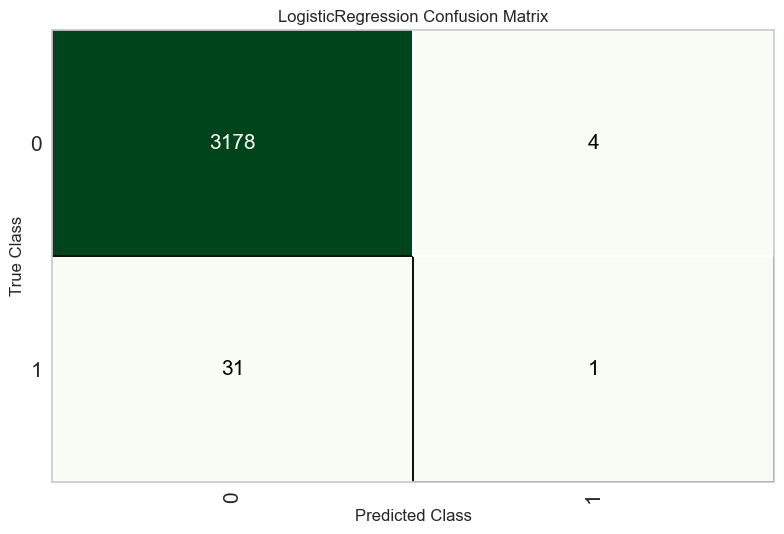

In [137]:
plot_model(lr, plot = 'confusion_matrix')

In [141]:
prediction = predict_model(lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9891,0.7652,0.0312,0.2000,0.0541,0.0515,0.0756


In [243]:
prediction.tail()

,attribute2,attribute4,attribute5,attribute3_g,attribute8,attribute9,failure,prediction_label,prediction_score
754,0,0,20,maior 0,0,33,0,0,0.62
5276,0,0,6,igual 0,0,12,0,0,0.70
7328,0,0,12,igual 0,0,0,0,0,0.81
8487,0,0,11,igual 0,0,0,0,0,0.88
3632,0,0,11,igual 0,0,0,0,0,0.88


In [143]:
prediction.groupby(['prediction_label'] , dropna=False)["attribute2"].count().reset_index()

,prediction_label,attribute2
0,0,3209
1,1,5


In [144]:
prediction.groupby(['prediction_score'] , dropna=False)["attribute2"].count().reset_index()

,prediction_score,attribute2
0,0.56,1
1,0.63,1
2,0.72,1
3,0.73,1
4,0.73,1
...,...,...
92,1.00,1
93,1.00,38
94,1.00,1
95,1.00,1


In [226]:
validation_predictions_2 = predict_model(lr, data=full_devices)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9989,0.8030,0.0566,0.1333,0.0795,0.0790,0.0864


In [227]:
validation_predictions_2.groupby(["failure", 'prediction_label'], dropna=False)["device"].count().reset_index()

,failure,prediction_label,device
0,0,0,124349
1,0,1,39
2,1,0,100
3,1,1,6


# Estratificado

amostra estratificada, isto é, serão usados 106 eventos 0 e os todos os 1 para modelar. 


In [244]:
np.random.seed(3)
random_index = np.random.randint(0,11370, (106))

In [245]:
no_failure_model = no_failure_devices[no_failure_devices.index.isin(random_index)]

In [246]:
devices_model = pd.concat([failure, no_failure_model, ])

In [247]:
devices_model.groupby(['failure'] , dropna=False)["attribute2"].count().reset_index()

,failure,attribute2
0,0,106
1,1,106


In [211]:
devices_model_estr = devices_model[['attribute2', 'attribute4', 'attribute5', 
                 'attribute3_g', 'attribute8','attribute9' , 'failure' ]]

In [212]:
model_clf02 = setup(data = devices_model_estr, target = 'failure', session_id=100)

,Description,Value
0,Session id,100
1,Target,failure
2,Target type,Binary
3,Original data shape,"(212, 7)"
4,Transformed data shape,"(212, 7)"
5,Transformed train set shape,"(148, 7)"
6,Transformed test set shape,"(64, 7)"
7,Ordinal features,1
8,Numeric features,5
9,Categorical features,1


In [213]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8119,0.8621,0.7196,0.8996,0.7846,0.6244,0.6492,0.1070
ada,Ada Boost Classifier,0.7843,0.8310,0.6893,0.8780,0.7548,0.5688,0.6006,0.0710
dt,Decision Tree Classifier,0.7790,0.7526,0.7054,0.8446,0.7554,0.5570,0.5763,0.0470
rf,Random Forest Classifier,0.7786,0.8344,0.7161,0.8429,0.7604,0.5541,0.5737,0.1160
et,Extra Trees Classifier,0.7781,0.8152,0.7304,0.8232,0.7605,0.5540,0.5696,0.1150
gbc,Gradient Boosting Classifier,0.7648,0.8393,0.6929,0.8420,0.7431,0.5295,0.5565,0.0740
lr,Logistic Regression,0.7576,0.7912,0.6036,0.9125,0.6998,0.5207,0.5719,0.0470
knn,K Neighbors Classifier,0.7448,0.8176,0.6250,0.8412,0.7053,0.4902,0.5145,0.0480
nb,Naive Bayes,0.7310,0.7622,0.5054,0.9457,0.6356,0.4643,0.5313,0.0460
svm,SVM - Linear Kernel,0.7233,0.0000,0.7714,0.7527,0.7337,0.4465,0.4585,0.0400


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [214]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8667,0.8839,0.8750,0.8750,0.8750,0.7321,0.7321
1,0.8000,0.9018,0.6250,1.0000,0.7692,0.6087,0.6614
2,0.8000,0.8214,0.6250,1.0000,0.7692,0.6087,0.6614
3,0.6667,0.7143,0.5000,0.8000,0.6154,0.3478,0.3780
4,0.9333,0.9911,0.8571,1.0000,0.9231,0.8649,0.8729
5,0.8000,0.8482,0.8571,0.7500,0.8000,0.6018,0.6071
6,0.7333,0.7768,0.4286,1.0000,0.6000,0.4444,0.5345
7,0.7333,0.7857,0.7143,0.7143,0.7143,0.4643,0.4643
8,0.9286,0.9388,0.8571,1.0000,0.9231,0.8571,0.8660


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

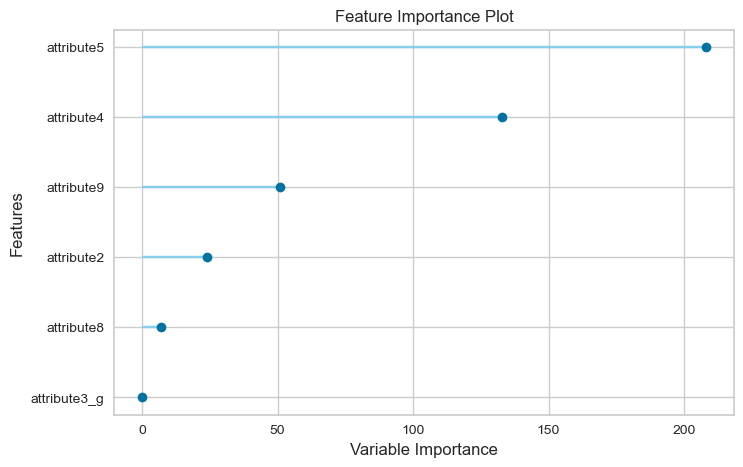

In [215]:
plot_model(lightgbm, plot='feature')

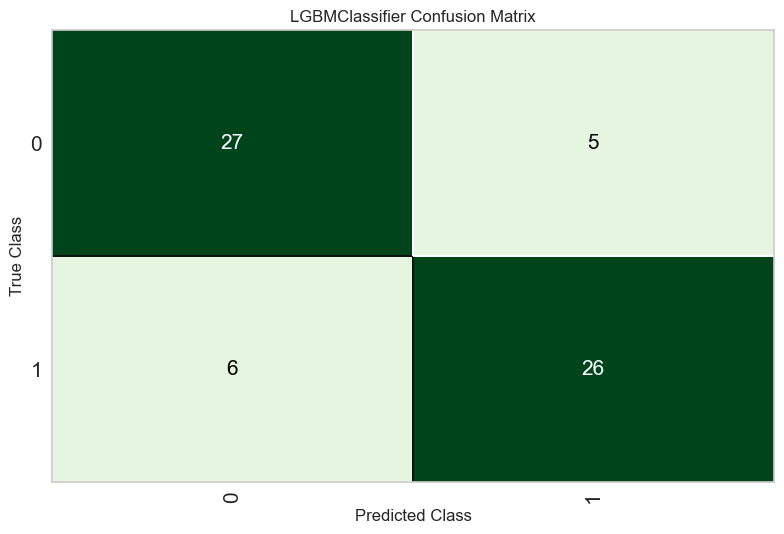

In [216]:
plot_model(lightgbm, plot = 'confusion_matrix')

In [217]:
prediction = predict_model(lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8281,0.8667,0.8125,0.8387,0.8254,0.6562,0.6566


In [218]:
prediction.head()

,attribute2,attribute4,attribute5,attribute3_g,attribute8,attribute9,failure,prediction_label,prediction_score
2779,0,0,6,igual 0,0,0,0,0,0.86
76263,0,0,14,igual 0,832,5,1,1,0.71
15898,1184,0,14,igual 0,8,0,1,1,0.92
6655,0,0,8,igual 0,0,0,0,0,0.72
3372,0,0,9,igual 0,0,13,0,1,0.58


In [221]:
prediction.groupby("prediction_label" , dropna=False)["attribute2"].count().reset_index()

,prediction_label,attribute2
0,0,33
1,1,31


In [236]:
validation_predictions = predict_model(lightgbm, data=full_devices)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8635,0.8905,0.7830,0.0049,0.0097,0.0080,0.0549


In [237]:
validation_predictions.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,attribute3_g,failure,prediction_label,prediction_score
0,2015-01-01,S1F01085,215630672,56,0,52,6,407438,0,0,7,igual 0,0,1,0.94
1,2015-01-01,S1F0166B,61370680,0,3,0,6,403174,0,0,0,maior 0,0,0,0.86
2,2015-01-01,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,igual 0,0,0,0.81
3,2015-01-01,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,igual 0,0,0,0.86
4,2015-01-01,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,igual 0,0,0,0.62


In [238]:
validation_predictions.groupby(["failure", 'prediction_label'], dropna=False)["device"].count().reset_index()

,failure,prediction_label,device
0,0,0,107422
1,0,1,16966
2,1,0,23
3,1,1,83


Text(0.5, 0, 'Score')

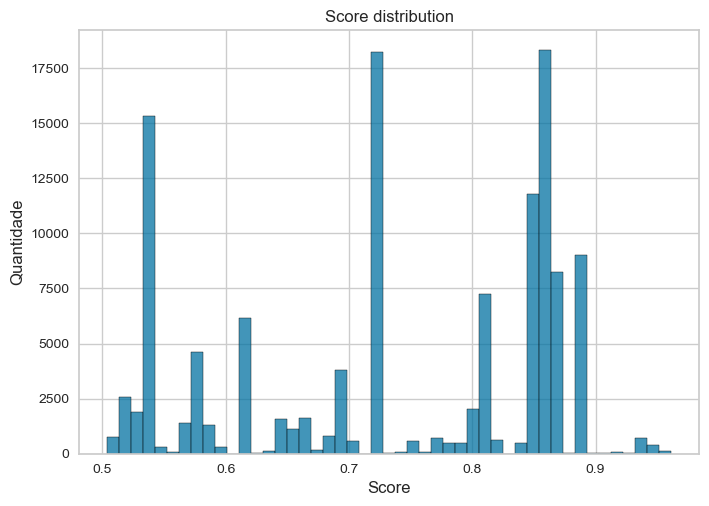

In [239]:
ax = sns.histplot(data=validation_predictions, x="prediction_score")
ax.set_title('Score distribution')
ax.set_ylabel('Quantidade')
ax.set_xlabel('Score')

In [241]:
validation_predictions['prediction_score_g'] = pd.cut(x=validation_predictions['prediction_score'], bins=[0, 0.9, 2],
                    labels=['[0 a 0.9]', ']0.9 a 1]' ])

In [242]:
validation_predictions.groupby(["failure", 'prediction_score_g'], dropna=False)["device"].count().reset_index()

,failure,prediction_score_g,device
0,0,[0 a 0.9],123085
1,0,]0.9 a 1],1303
2,1,[0 a 0.9],63
3,1,]0.9 a 1],43


In [233]:
falso_posito = validation_predictions[(validation_predictions['prediction_label']==1) &
                       (validation_predictions['failure']==0) ]

acerto_1 = validation_predictions[(validation_predictions['prediction_label']==1) &
                       (validation_predictions['failure']==1) ]

acerto_0 = validation_predictions[(validation_predictions['prediction_label']==0) &
                       (validation_predictions['failure']==0) ]

Text(0.5, 0, 'Score')

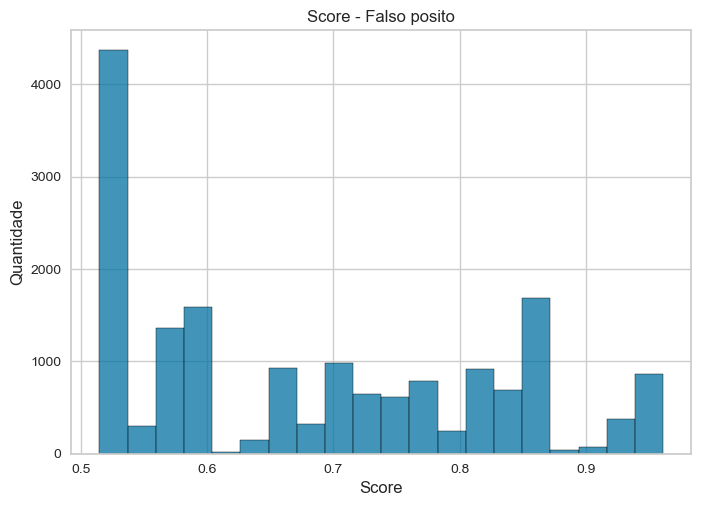

In [230]:
ax = sns.histplot(data=falso_posito, x="prediction_score")
ax.set_title('Score - Falso posito')
ax.set_ylabel('Quantidade')
ax.set_xlabel('Score')

Text(0.5, 0, 'Score')

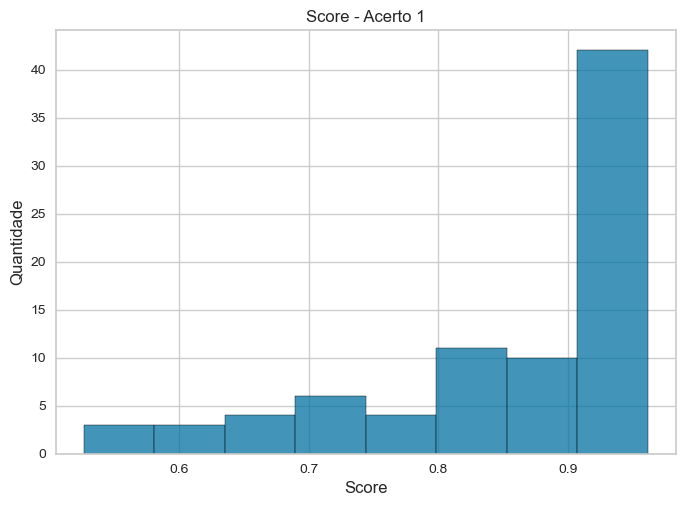

In [234]:
ax = sns.histplot(data=acerto_1, x="prediction_score")
ax.set_title('Score - Acerto 1')
ax.set_ylabel('Quantidade')
ax.set_xlabel('Score')

Text(0.5, 0, 'Score')

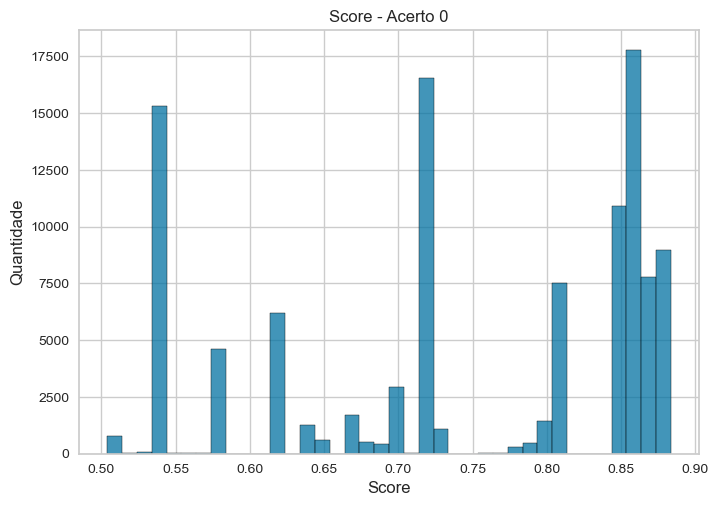

In [235]:
ax = sns.histplot(data=acerto_0, x="prediction_score")
ax.set_title('Score - Acerto 0')
ax.set_ylabel('Quantidade')
ax.set_xlabel('Score')

In [248]:
# apos finalizar o modelo, ele deve ser salvo como o modelo abaixo

In [249]:
final_lightgbm = finalize_model(lightgbm)

In [250]:
print(final_lightgbm)

Pipeline(memory=FastMemory(location=C:\Users\marci\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['attribute2', 'attribute4',
                                             'attribute5', 'attribute8',
                                             'attribute9'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verb...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,

In [251]:
save_model(final_lightgbm,'Final Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\marci\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['attribute2', 'attribute4',
                                              'attribute5', 'attribute8',
                                              'attribute9'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verb...
                  LGBMClassifier(boosting_type='gbdt', clas